# World and Simulator with ODE solver

Once you read through [1. Brief Tour of E-Cell4 Simulations](1. Brief Tour of E-Cell4 Simulations), it is NOT difficult to use `World` and `Simulator`.
`volume` and `{'C': 60}` is equivalent of the `World` and solver is the `Simulator` below.

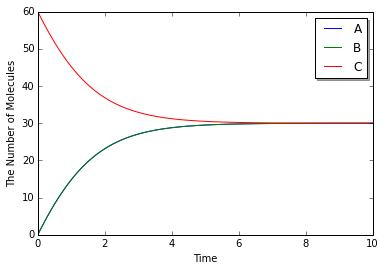

In [1]:
%matplotlib inline
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

y = run_simulation(10.0, {'C': 60}, volume=1.0)

Here we give you a breakdown for `run_simulation`.
`run_simulation` use ODE simulator by default, so we create `ODEWorld` step by step.

## Creating ODE world

You can create `World` like this.

In [2]:
w = ode.ODEWorld(Real3(1, 1, 1))

`Real3` is a coordinate vector.
In this example, the first argument for `ODEWorld` constructor is a cube.
Note that you can NOT use volume for `ode.ODEWorld` argument, like `run_simulation` argument.

Now you created a cube box for simulation, next let's throw molecules into the cube.

In [3]:
w = ode.ODEWorld(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)
print(w.t(), w.num_molecules(Species('C')))  # must return (0.0, 60)

(0.0, 60)


Use `add_molecules` to add molecules, `remove_molecules` to remove molecules, `num_molecules` to know the number of molecules.
First argument for each method is the `Species` you want to know.
You can get current time by `t` method.
However the number of molecules in ODE solver is real number, in these `_molecules` functions work only for integer number.
When you handle real numbers in ODE, use `set_value` and `get_value`.

## How to use Real3

Before the detail of `Simulator`, we explaing more about `Real3`.

In [4]:
pos = Real3(1, 2, 3)
print(pos)  # must print like <ecell4.core.Real3 object at 0x7f44e118b9c0>
print(tuple(pos))  # must print (1.0, 2.0, 3.0)

(1.0, 2.0, 3.0)


You can not print the contents in `Real3` object directly.
You need to convert `Real3` to Python tuple or list once.

In [5]:
pos1 = Real3(1, 1, 1)
x, y, z = pos[0], pos[1], pos[2]
pos2 = pos1 + pos1
pos3 = pos1 * 3
pos4 = pos1 / 5
print(length(pos1))  # must print 1.73205080757
print(dot_product(pos1, pos3))  # must print 9.0

1.73205080757
9.0


You can use basic function like `dot_product`.
Of course, you can convert `Real3` to numpy array too.

In [7]:
import numpy
a = numpy.asarray(tuple(Real3(1, 2, 3)))
print(a)  # must print [ 1.  2.  3.]

[ 1.  2.  3.]


## Creating and Running ODESimulator

You can create a `Simulator` with `Model` and `World` like 

In [8]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m = get_model()

sim = ode.ODESimulator(m, w)
sim.run(10.0)

then call `run` method, the simulation will run.
In this example the simulation runs for 10seconds.

You can check the state of the `World` like this.

In [9]:
print(w.t(), w.num_molecules(Species('C')))  # must return (10.0, 30)

(10.0, 30)


You can see that the number of the `Species` `C` decreases from 60 to 30.

`World` describes the state of a timepoint, so you can NOT see the transition of the simulation with the `World`.
To obtain the time-series result, use `Observer`.

In [14]:
w = ode.ODEWorld(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)
sim = ode.ODESimulator(m, w)

obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10.0, obs)
print(obs.data())  # must return [[0.0, 0.0, 60.0], ..., [10.0, 29.994446899691276, 30.005553100308752]]

[[0.0, 0.0, 60.0], [0.1, 1.7722206098711988, 58.227779390128795], [0.2, 3.4860124889661757, 56.51398751103382], [0.30000000000000004, 5.1376332715496495, 54.862366728450354], [0.4, 6.724090809612153, 53.27590919038786], [0.5, 8.243129756755453, 51.75687024324456], [0.6000000000000001, 9.69320376680592, 50.3067962331941], [0.7000000000000001, 11.073435590968808, 48.92656440903121], [0.8, 12.383567691608423, 47.616432308391595], [0.9, 13.62390591657045, 46.37609408342957], [1.0, 14.795258681171735, 45.20474131882829], [1.1, 15.898873899780316, 44.10112610021971], [1.2000000000000002, 16.936375633755194, 43.06362436624483], [1.3, 17.90970211303103, 42.090297886969], [1.4000000000000001, 18.821046466966358, 41.17895353303366], [1.5, 19.67280118133671, 40.32719881866331], [1.6, 20.46750699887015, 39.53249300112988], [1.7000000000000002, 21.207806714875233, 38.792193285124796], [1.8, 21.896404094818397, 38.10359590518163], [1.9000000000000001, 22.536027939969333, 37.463972060030684], [2.0, 2

There are several types of `Observer`s for E-Cell4.
`FixedIntervalNumberObserver` is the simplest `Observer` to obtain the time-series result.
As its name suggests, this `Observer` records the number of molecules for each time-step.
The 1st argument is the time-step, the 2nd argument is the molecule types.
You can check the result with `data` method, but there is a shortcut for this.

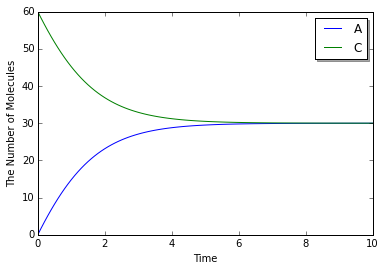

In [15]:
viz.plot_number_observer(obs)

This plots the time-series result easily.

We explained the internal of `run_simulation` function.
When you change the `World` after creating the `Simulator`, you need to indicate it to `Simulator`.
So do NOT forget to call `sim.initialize()` after that.

## Switching the solver

It is NOT difficult to switch the solver to stochastic method, as we showed `run_simulation`.

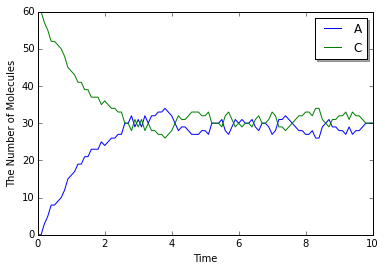

In [16]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

# ode.ODEWorld -> gillespie.GillespieWorld
w = gillespie.GillespieWorld(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)

# ode.ODESimulator -> gillespie.GillespieSimulator
sim = gillespie.GillespieSimulator(m, w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10.0, obs)

viz.plot_number_observer(obs)

`World` and `Simulator` never change the `Model` itself, so you can switch several `Simulator`s for 1 `Model`.